### ARIMA Modeling for Brent Crude Oil Price Forecasting


In [11]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [3]:
import os
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

data_path= os.path.join(BASE_DIR, "data","processed","brent_daily_clean.csv" )
df=pd.read_csv(data_path)

In [5]:
df.head()

,date,price
0,1987-05-20,18.630000
1,1987-05-21,18.450000
2,1987-05-22,18.550000
3,1987-05-23,18.566667
4,1987-05-24,18.583333


In [6]:
split_idx= int(len(df)*0.8)

train=df.iloc[:split_idx]
val =df.iloc[split_idx:]

train.shape, val.shape

((11294, 2), (2824, 2))

### Stationarity Test Using Augmented Dickey-Fuller (ADF)


In [10]:
from statsmodels.tsa.stattools import adfuller

result=adfuller(train["price"])
print("ADF Statistics:", result[0])
print("p-value:", result[1])

ADF Statistics: -1.6763900906168496
p-value: 0.4433162187868928


### Stationarity Check
The Augmented Dickey-Fuller (ADF) test was applied to the training time series to check for stationarity.

- **ADF Statistic:** -1.676  
- **p-value:** 0.443

Since the p-value is **greater than 0.05**, we fail to reject the null hypothesis.  
This indicates that the Brent crude oil price series is **non-stationary**.


The original time series is **not stationary** and therefore **can**


In [12]:
train_diff = train['price'].diff().dropna()
train_diff.head()


1   -0.180000
2    0.100000
3    0.016667
4    0.016667
5    0.016667
Name: price, dtype: float64

In [13]:
result = adfuller(train_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -14.742404087549108
p-value: 2.5586789095206565e-27


### Differencing and Stationarity Re-check

Since the original Brent oil price series was non-stationary, first-order differencing was applied to remove trend effects.  
Differencing computes the change between consecutive observations, helping stabilize the mean of the series.  
The Augmented Dickey-Fuller (ADF) test was then re-applied to confirm whether the differenced series achieved stationarity, which is required before fitting an ARIMA model.


### Stationarity After Differencing – Conclusion

After applying first-order differencing, the Augmented Dickey-Fuller (ADF) test shows a p-value close to zero  
(p-value ≈ 2.56e-27), which is far below the 0.05 significance level.  
This confirms that the differenced series is **stationary**, making it suitable for ARIMA modeling with d = 1.


In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

<Figure size 600x200 with 0 Axes>

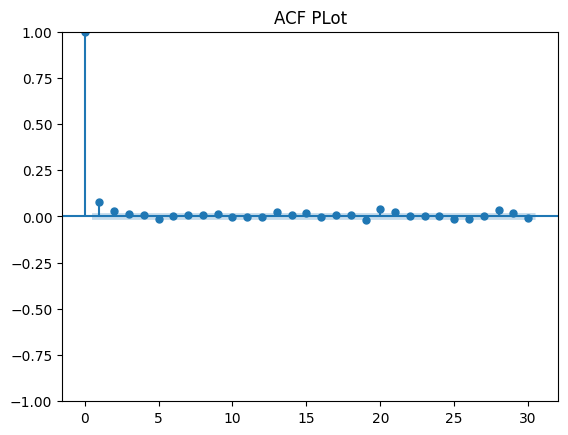

<Figure size 600x200 with 0 Axes>

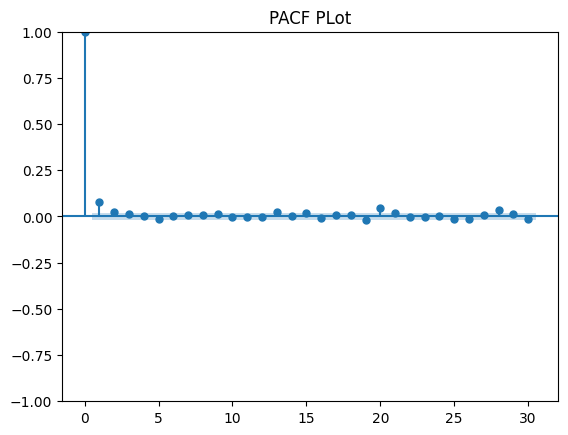

In [18]:
plt.figure(figsize=(6,2))
plot_acf(train_diff, lags=30)
plt.title("ACF PLot")
plt.show()

plt.figure(figsize=(6,2))
plot_pacf(train_diff, lags=30)
plt.title("PACF PLot")
plt.show()

### ACF–PACF Interpretation

The ACF plot shows a significant spike at lag 1 followed by an immediate cutoff, suggesting an MA(1) component.  
Similarly, the PACF plot shows a strong spike at lag 1 with no significant higher-order lags, indicating an AR(1) component.  

Based on these observations and first-order differencing (d = 1), the selected model is **ARIMA(1, 1, 1)**.


In [22]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(train["price"], order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                11294
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13606.790
Date:                Mon, 19 Jan 2026   AIC                          27219.579
Time:                        07:42:40   BIC                          27241.575
Sample:                             0   HQIC                         27226.980
                              - 11294                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3642      0.057      6.439      0.000       0.253       0.475
ma.L1         -0.2858      0.058     -4.938      0.000      -0.399      -0.172
sigma2         0.6517      0.003    225.344      0.000       0.646       0.657
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            126494.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.34   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA(1,1,1) Model Interpretation

Both AR(1) and MA(1) coefficients are statistically significant (p < 0.05), confirming the suitability of the selected ARIMA(1,1,1) model.  
The Ljung-Box test indicates no remaining autocorrelation in residuals, suggesting the model captures temporal structure effectively.  
Although residuals deviate from normality (high kurtosis), this behavior is typical for crude oil prices and does not invalidate forecasting performance.


In [23]:
forecast=model_fit.forecast(steps=len(val))
forecast.head()

11294    74.639129
11295    74.646097
11296    74.648634
11297    74.649559
11298    74.649895
Name: predicted_mean, dtype: float64

In [25]:
forecast = pd.Series(forecast, index=val.index)

In [28]:
last_train_price = train['price'].iloc[-1]
val['naive_forecast'] = last_train_price


C:\Users\Aman Deep\AppData\Local\Temp\ipykernel_29264\3650244568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['naive_forecast'] = last_train_price


In [29]:
baseline_mae = mean_absolute_error(val['price'], val['naive_forecast'])
baseline_rmse = np.sqrt(mean_squared_error(val['price'], val['naive_forecast']))

baseline_mae, baseline_rmse


(13.186826605288008, np.float64(18.253299252911084))

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

arima_mae = mean_absolute_error(val['price'], forecast)
arima_rmse = np.sqrt(mean_squared_error(val['price'], forecast))

arima_mae, arima_rmse


(13.18941361880092, np.float64(18.25639363024561))

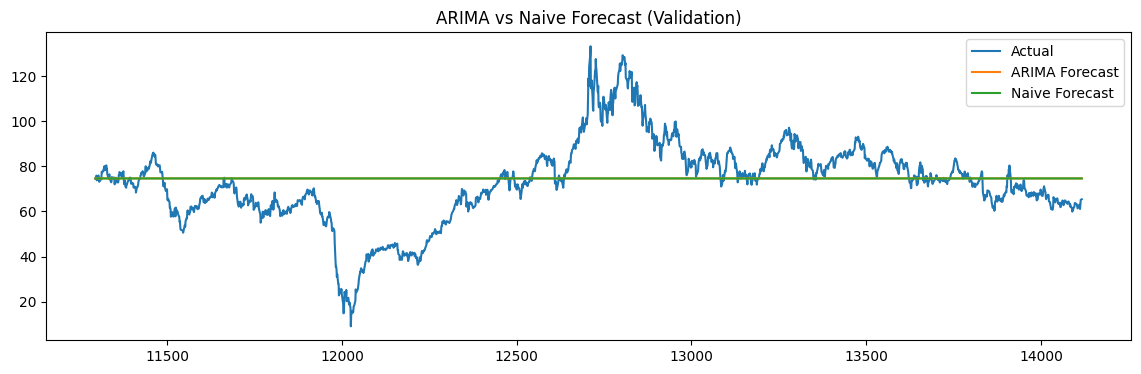

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))
plt.plot(val.index, val['price'], label='Actual')
plt.plot(val.index, forecast, label='ARIMA Forecast')
plt.plot(val.index, val['naive_forecast'], label='Naive Forecast')
plt.legend()
plt.title("ARIMA vs Naive Forecast (Validation)")
plt.show()


### Model Performance Comparison

The ARIMA(1,1,1) model achieves MAE and RMSE values that are nearly identical to the naive baseline.  
This indicates that the ARIMA model does not provide a significant improvement over a simple persistence-based forecast.  
Such behavior is common for highly volatile and shock-driven time series like crude oil prices, highlighting the limitations of classical ARIMA models in this context.
